In [1]:
%reload_ext autoreload
%autoreload 2

In [12]:
from typing import *
import math
import torch
from torch import nn
import torch.nn.functional as F
from einops import rearrange
from timm.models.layers import DropPath
from timm.models.layers.helpers import to_2tuple
import functools as ft
import numbers
from tqdm import tqdm
import matplotlib.pyplot as plt

from timm.models.energy_transformer import ClassicalHopfield, HopfieldMLP, KQEnergyBlock, KQAlignedAttention, EnergyLayerNorm

In [6]:
def ifnone(a,b):
    if a is None:
        return b
    return a

In [8]:
mod = HopfieldMLP(768, 4*768, bias=False).to(0)
x = torch.randn((32, 768), device=0)

In [9]:
depth = 100
alpha = 0.1
norm = nn.LayerNorm(x.shape[-1], elementwise_affine=False)
xx = x
energies = [mod.energy(xx)]
with torch.no_grad():
    for i in range(depth):
        g = norm(xx)
        xx = x - mod(g)
        energies.append(mod.energy(xx))
energies = torch.stack(energies)

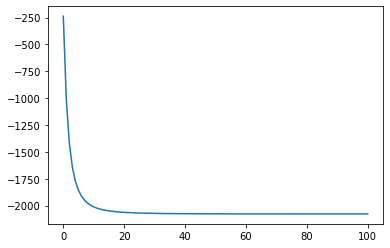

In [10]:
plt.plot(energies.detach().cpu().numpy()[:,0])

In [13]:
#hide
bs, N, dim = 32,196,768
nheads=8
attn = KQAlignedAttention(dim, nheads, False, head_dim=64).to(0)
toks = torch.randn(bs,N,dim).to(0)
toks_out = attn(toks)

In [14]:
[k for k,v in attn.named_parameters()]

['betas', 'q_proj.weight', 'k_proj.weight']

In [15]:
# Naive check: am I descending energy?
alpha = 1
depth = 100
x = toks
norm = nn.LayerNorm(x.shape[-1], elementwise_affine=False, device=x.device)
energies = [attn.energy(norm(x))]
with torch.no_grad():
    for i in tqdm(range(depth)):
        g = norm(x)
        x = x - alpha*attn(g)
        energies.append(attn.energy(norm(x)))
    
energies=torch.stack(energies)

100%|██████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 143.77it/s]


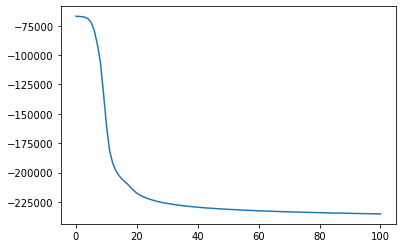

In [16]:
plt.plot(energies[:,0].detach().cpu().numpy())

In [17]:
class EnergyLayerNorm(nn.Module):
    def __init__(self, normalized_shape: Union[int, List[int], torch.Size], eps: float=1e-5, train_scale=True, train_bias=True, device=None, dtype=None):
        """An energy plausible version of layernorm, assumes the dimension of interest is dim=-1"""
        factory_kwargs = {'device': device, 'dtype': dtype}
        super().__init__()
        self.train_scale = train_scale
        self.train_bias = train_bias
        self.normalized_shape=normalized_shape
        
        if self.train_scale:
            self.weight = nn.Parameter(torch.empty(1, **factory_kwargs))
        else:
            self.register_parameter('weight', None)
            
        if self.train_bias:
            self.bias = nn.Parameter(torch.empty(self.normalized_shape, **factory_kwargs))
        else:
            self.register_parameter('bias', None)
        
        self.reset_parameters()
        
    def reset_parameters(self) -> None:
        if self.train_scale:
            nn.init.ones_(self.weight)
        if self.train_bias:
            nn.init.zeros_(self.bias)
            
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        weight = self.weight if self.train_scale else 1.
        bias = self.bias if self.train_bias else 0.
                
        std, mean = torch.std_mean(x, -1, keepdim=True)
        return weight * (x - mean) / std + bias 
    
class KQEnergyBlock(nn.Module):
    def __init__(
            self, dim, num_heads, mlp_ratio=4., qkv_bias=False, init_values=None, act_layer=nn.ReLU):#, norm_layer=EnergyLayerNorm):
        super().__init__()
        self.attn = KQAlignedAttention(dim, num_heads=num_heads, qkv_bias=qkv_bias)
        self.chn = HopfieldMLP(in_features=dim, hidden_features=int(dim * mlp_ratio), act_layer=act_layer)

    def forward(self, g, alpha=0.1):
        return self.attn(g) + self.chn(g)

    def energy(self, x):
        return self.attn.energy(x) + self.chn.energy(x).sum(-1)

In [18]:
block = KQEnergyBlock(768, 8).to(toks.device)

In [19]:
# Naive check: am I descending energy?
alpha = 0.1
depth = 1000
n_energies = 1000
energy_every = depth // n_energies
x = toks[:1]
norm = EnergyLayerNorm(x.shape[-1], device=x.device)
energies = torch.empty(n_energies+1)
energies[0] = block.energy(norm(x))[0]
with torch.no_grad():
    for i in tqdm(range(depth)):
        g = norm(x)
        x = x - alpha*block(g)
        if ((i+1)%energy_every) == 0:
            j = (i+1) // energy_every
            energies[j] = block.energy(norm(x))[0]

100%|████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 499.62it/s]


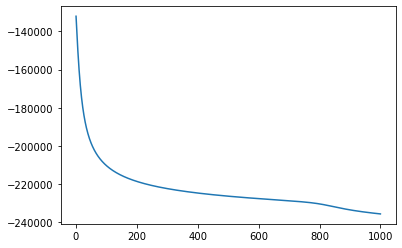

In [20]:
plt.plot(energies.detach().cpu().numpy())

In [24]:
from timm.models.helpers import checkpoint_seq

In [30]:
from timm.models.energy_transformer import EnergyVisionTransformer

In [81]:
bs, C,H,W = 7, 3, 224, 224
x = torch.randn((bs,C,H,W)).to(0)
model=EnergyVisionTransformer(embed_dim=768, num_heads=8, qkv_bias=False, depth=1).to(0)

In [82]:
y = model.forward_features(x)